In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
import os
import glob
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import cv2
import random 
import math
import threading

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd "/content/gdrive/My Drive/Colab Notebooks/CNN_Utility"

/content/gdrive/My Drive/Colab Notebooks/CNN_Utility


In [0]:
data_transforms = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [0]:
def get_classes():
  path='tiny-imagenet-200/wnids.txt'
  class_dict={}
  count=0
  with open(path) as file:
    for line in file:
      class_dict[line.strip()]=count
      count+=1
  return class_dict

In [7]:
from dataloaders import transformations,AlbumentationWrapper
from models import BasicBlock,Bottleneck,ResNet,ResNet18,model_params,Net,model_params
from graphs_and_other_utility_functions import plot,save_model,get_lr,plot_misclassified_gradcam_images,plotLRFinder
from train_test import train,test
from lr_finder import LRFinder
import grad_cam
from main import demo1

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
train_image_datasets = datasets.ImageFolder('tiny-imagenet-200/train',data_transforms)

In [9]:
len(train_image_datasets)

96771

In [0]:
cuda = torch.cuda.is_available()
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=10, pin_memory=True) if cuda else dict(shuffle=False, batch_size=128)
#trainloader = torch.utils.data.DataLoader(train_image_datasets, **dataloader_args)

In [0]:
train_set,test_set=torch.utils.data.random_split(train_image_datasets, [68000,(96771-68000)])

In [0]:
trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)

In [0]:
testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)

532
225
(64, 64, 3)


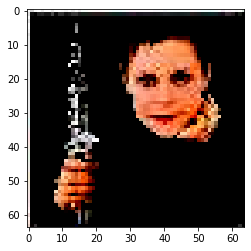

In [16]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(len(trainloader))
print(len(testloader))
X = images.numpy().transpose([0, 2, 3, 1])
print(X[22].shape)
plt.imshow(X[0])

In [0]:
model =  ResNet18(len(get_classes())).to(device)
lrr=0.001
optimizer1 = optim.SGD(model.parameters(), lr=lrr, momentum=0.9)#, weight_decay=9e-4)
scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimizer1, max_lr=lrr*10, pct_start=0.21 , steps_per_epoch=len(trainloader), div_factor=10, cycle_momentum=False, epochs=24)
epochs=10
input_size=(3,64,64)

  0%|          | 0/532 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

Loss=4.036650657653809 Batch_id=531 le=0.0018468899783472149 Accuracy=4.94: 100%|██████████| 532/532 [41:28<00:00,  4.68s/it]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 2301/28771 (8.00%)

EPOCH: 1 LR: 0.0018468899783472149 


Loss=4.153738021850586 Batch_id=531 le=0.004068794297644442 Accuracy=12.02: 100%|██████████| 532/532 [06:26<00:00,  1.37it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 3453/28771 (12.00%)

EPOCH: 2 LR: 0.004068794297644442 


Loss=3.3608908653259277 Batch_id=531 le=0.006829398068620918 Accuracy=18.40: 100%|██████████| 532/532 [06:26<00:00,  1.38it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 4530/28771 (15.75%)

EPOCH: 3 LR: 0.006829398068620918 


Loss=3.0129799842834473 Batch_id=531 le=0.00908962232779775 Accuracy=24.53: 100%|██████████| 532/532 [06:26<00:00,  1.38it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 6473/28771 (22.50%)

EPOCH: 4 LR: 0.00908962232779775 


Loss=3.4604196548461914 Batch_id=531 le=0.009998728731213106 Accuracy=30.90: 100%|██████████| 532/532 [06:25<00:00,  1.38it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 6093/28771 (21.18%)

EPOCH: 5 LR: 0.009998728731213106 


Loss=2.2723946571350098 Batch_id=531 le=0.009936630432037444 Accuracy=36.35: 100%|██████████| 532/532 [06:28<00:00,  1.37it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 8705/28771 (30.26%)

EPOCH: 6 LR: 0.009936630432037444 


Loss=3.0681040287017822 Batch_id=531 le=0.009738136088096358 Accuracy=41.64: 100%|██████████| 532/532 [06:29<00:00,  1.36it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9660/28771 (33.58%)

EPOCH: 7 LR: 0.009738136088096358 


Loss=1.8574508428573608 Batch_id=531 le=0.009409854453666896 Accuracy=46.56: 100%|██████████| 532/532 [06:28<00:00,  1.37it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 10850/28771 (37.71%)

EPOCH: 8 LR: 0.009409854453666896 


Loss=2.206944704055786 Batch_id=531 le=0.00896077793265593 Accuracy=51.07: 100%|██████████| 532/532 [06:25<00:00,  1.38it/s]
  0%|          | 0/532 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 10520/28771 (36.56%)

EPOCH: 9 LR: 0.00896077793265593 


Loss=1.6683518886566162 Batch_id=531 le=0.00840320778422175 Accuracy=55.85: 100%|██████████| 532/532 [06:28<00:00,  1.37it/s]



Test set: Average loss: 0.0202, Accuracy: 11547/28771 (40.13%)



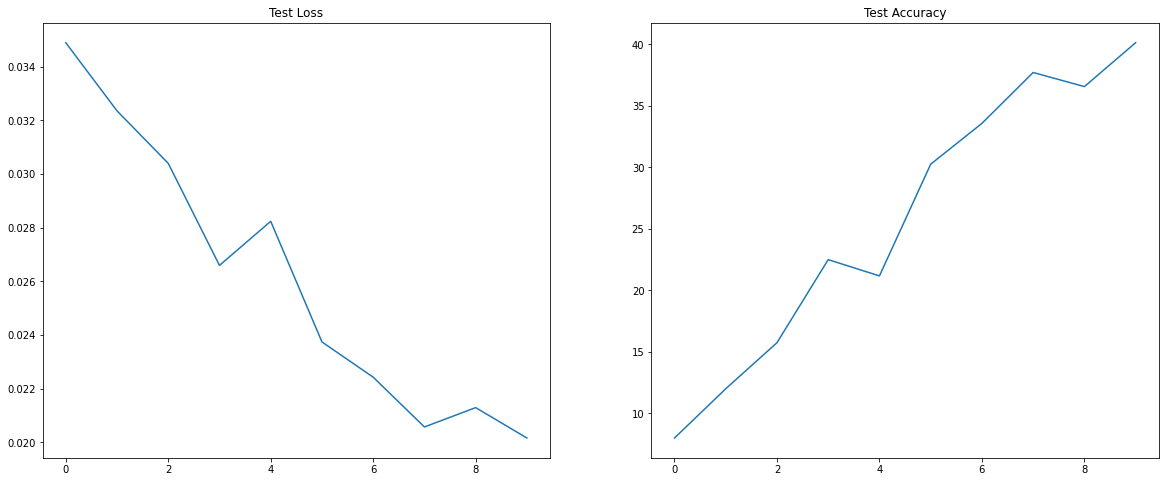

In [18]:
train_losses_without_L1_L2 = []
test_losses_without_L1_L2 = []
train_acc_without_L1_L2 = []
test_acc_without_L1_L2 = []
best_loss = 1000.0
misclassified_list = {}
model_params(model, input_size,device)  

for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer1)))
    best_loss=train(model, device, trainloader, optimizer1, scheduler1, epoch, False, train_acc_without_L1_L2, train_losses_without_L1_L2, best_loss, False)
    test(model, device, testloader, test_acc_without_L1_L2, test_losses_without_L1_L2, misclassified_list)
    #scheduler.step()
plot(train_losses_without_L1_L2,train_acc_without_L1_L2, test_losses_without_L1_L2, test_acc_without_L1_L2, 'without L1 and L2')